In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import  FluxPointsEstimator
    
from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : qZDUPe73 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

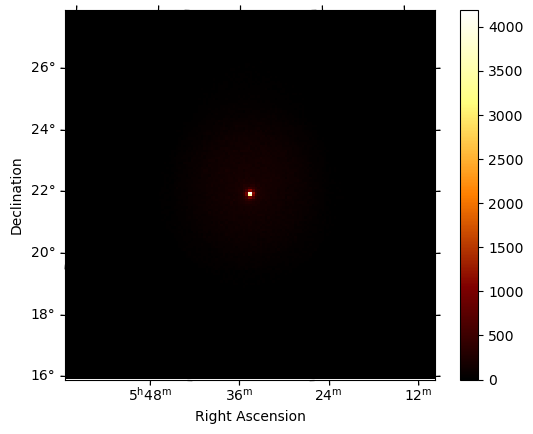

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [4]:
shift = +0.1
delta_tilt = 0.08
n = 24
tilt = delta_tilt/n 

N = 300
sigma_a = 0.1
sigma_i = tilt

save = True
save_flux = True




In [ ]:
for n in range(N):
    try:
        print(n)
        shift_rnd = np.random.normal(0, shift, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        print(f"shift:, {shift_rnd}, tilt: {tilt_rnd}" )
        sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_rnd, 
                        tilt = tilt_rnd,
                        rnd = True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/7a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(shift_rnd)) + '    '+ str(float(tilt_rnd)) + '    ' +  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'norm', 'tilt']:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        print(stri)
        if save:
            with open("data/7a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/7a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/7a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{shift_rnd[0]:.6}.fits')
    except:
        pass


0
shift:, [0.22194122], tilt: [0.00308056]
8.525168823666117e-13   7.57357602880006e-14   2.2910989075917265   0.06108764005514732   0.9993698455989053   0.002065076067264322   -0.0023561051410536417   0.001958095662812112   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.2833552936828745 1.0308432471284013
flux: len pen par: 0
norm 0.985198785461361 0.40910006052752806
flux: len pen par: 0
norm 1.0564289697293785 0.2058869389405636
flux: len pen par: 0
norm 0.8834541650742321 0.17199811678119373
flux: len pen par: 0
norm 1.1311698189869792 0.17985481964273073
flux: len pen par: 0
norm 0.9185614469894683 0.18239148843481523
flux: len pen par: 0
norm 1.0413365331531461 0.19877120458662698
flux: len pen par: 0
norm 0.9401496938059203 0.21222286926188944
flux: len pen par: 0
norm 1.065125908176956 0.2328845474981059
flux: len pen par: 0
norm 1.26631882866

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm -0.5003681392218249 0.8733742011858892
flux: len pen par: 0
norm 0.3288477915746103 0.35300525403541755
flux: len pen par: 0
norm 1.266622090049948 0.2087641769768709
flux: len pen par: 0
norm 1.1540510911529882 0.17715042070130532
flux: len pen par: 0
norm 0.9939150510818177 0.17649965099446818
flux: len pen par: 0
norm 0.7495830646680668 0.1758169949965157
flux: len pen par: 0
norm 1.0009363135419365 0.2042608742876716
flux: len pen par: 0
norm 1.0645907591315362 0.22343114920542673
flux: len pen par: 0
norm 0.930273882480868 0.23629271728816287
flux: len pen par: 0
norm 1.0967792282068265 0.2693569315684551
flux: len pen par: 0
norm 0.8731223626424165 0.2929497017927241
flux: len pen par: 0
norm 0.9632260467757969 0.3363694400212929
flux: len pen par: 0
norm 1.106642347042543 0.39633101223271394
flux: len pen par: 0
norm 1.70844661

norm 1.1431094236639292 0.20865228716897277
flux: len pen par: 0
norm 1.0861783687012432 0.17546545937239788
flux: len pen par: 0
norm 0.8411610924501235 0.1716628102681079
flux: len pen par: 0
norm 0.814875088338204 0.1748002240145501
flux: len pen par: 0
norm 1.1997594479454519 0.2026652395390256
flux: len pen par: 0
norm 0.7590486315941567 0.20496170640669112
flux: len pen par: 0
norm 0.7725433546770305 0.21475696638993794
flux: len pen par: 0
norm 0.8725847617336049 0.2484238770626339
flux: len pen par: 0
norm 1.5636918932865769 0.3175819287232006
flux: len pen par: 0
norm 1.314283631040711 0.3469121677023795
flux: len pen par: 0
norm 1.077742760741901 0.3555279281116215
flux: len pen par: 0
norm 1.0083587278394992 0.40591264608602673
flux: len pen par: 0
norm 1.4098193001127188 0.5350975491528187
flux: len pen par: 0
norm 0.30497844745383357 0.3546434929902694
flux: len pen par: 0
norm 0.7012235465799979 0.5856088797407766
flux: len pen par: 0
norm 1.0622800999291049 0.79126358841

norm 1.328403330331776 0.22483096042252682
flux: len pen par: 0
norm 1.0537257877153214 0.23606130734697697
flux: len pen par: 0
norm 1.1654002795175762 0.2636266810824285
flux: len pen par: 0
norm 0.9148800924939426 0.28162936064900057
flux: len pen par: 0
norm 0.5280587263224735 0.27200294233489763
flux: len pen par: 0
norm 1.4851094783358572 0.4036249481273284
flux: len pen par: 0
norm 0.7833526273316676 0.3894335529649418
flux: len pen par: 0
norm 0.8598474709219125 0.49303944471131983
flux: len pen par: 0
norm 1.6585381477842815 0.6374765282755727
flux: len pen par: 0
norm 0.3140598267140166 0.5076500726870318
flux: len pen par: 0
norm -0.40670630991854206 0.05944721762728247
flux: len pen par: 0
norm 2.7453526027499584 1.2095387818947827
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
16
shift:, [-0.09636683], tilt: [-0.0013801]
1.0957678559805995e-12   9.949783462319703e-14   2.3653503383329766   0.06634486512483552   0.9977176158892358   0.0020634992437292264   -0.00051236

norm 0.938200035036221 0.27698555923447654
flux: len pen par: 0
norm 1.3201019301047485 0.3333781844830606
flux: len pen par: 0
norm 1.2331246656028874 0.3737227359615592
flux: len pen par: 0
norm 1.3999063173363993 0.4350264269160928
flux: len pen par: 0
norm 1.4418821608284649 0.45278248190737563
flux: len pen par: 0
norm 0.5006010071938702 0.37477918533185745
flux: len pen par: 0
norm 0.6933365175558419 0.5199332539800022
flux: len pen par: 0
norm 1.1863309672633002 0.6604368354366507
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
21
shift:, [-0.05266557], tilt: [-0.00907601]
9.645033530741395e-13   8.94855039645373e-14   2.3144074521128557   0.06300787097628834   1.0011843223551056   0.0020676494551089704   0.0005407673021498973   0.0019612478194717784   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.9165791317932486 1.1359128030221681
flux:

norm 1.8399999980531438 0.6558740312222312
flux: len pen par: 0
norm 0.9078228677840172 0.6363311766901877
flux: len pen par: 0
norm 0.48900459323653145 0.5880195147886537
flux: len pen par: 0
norm -0.35235681739252034 0.12742332443512355
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
26
shift:, [-0.0317536], tilt: [-0.00013372]
1.155344437052914e-12   1.0813915653446967e-13   2.3930377621083725   0.06633428397036785   0.9984835112725782   0.0020673157459777276   -0.0007752512542913177   0.001963120740445353   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.5144084477247791 0.84838654704678
flux: len pen par: 0
norm 0.6199361386259856 0.3444740909432955
flux: len pen par: 0
norm 0.857463267057447 0.18812347203765237
flux: len pen par: 0
norm 1.2766777293165341 0.1738002453645617
flux: len pen par: 0
norm 0.9631348397680446 0.17008311817393143
flu

31
shift:, [0.02280691], tilt: [-0.00591317]
8.891665575745235e-13   8.497592017176175e-14   2.304764303285642   0.06367047595861744   0.998428558969353   0.0020646027691546983   -0.0005073105792987166   0.0019619168211707978   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.2419623319660107 1.2386469936805757
flux: len pen par: 0
norm 0.8619662854372299 0.41861345559406665
flux: len pen par: 0
norm 0.9540322148727249 0.218348102112037
flux: len pen par: 0
norm 0.9609361998024536 0.18664904196360205
flux: len pen par: 0
norm 0.9707885058193326 0.19266732823300936
flux: len pen par: 0
norm 1.5213562277410404 0.2118275928193377
flux: len pen par: 0
norm 0.9020305086675641 0.20505707560366282
flux: len pen par: 0
norm 0.5951674531960233 0.20595728055518384
flux: len pen par: 0
norm 0.8054778488097585 0.22654205732017518
flux: len pen par: 0
norm 0.9315549

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.840236136422132 1.1224145078865877
flux: len pen par: 0
norm 0.9831863858989555 0.42767684008603335
flux: len pen par: 0
norm 0.9125229631577867 0.21355623402608812
flux: len pen par: 0
norm 0.8101615748212261 0.17615948708234802
flux: len pen par: 0
norm 1.0647316622713652 0.1802027050903377
flux: len pen par: 0
norm 1.0834422716045167 0.18470427505937384
flux: len pen par: 0
norm 0.886186768814796 0.18676405423150744
flux: len pen par: 0
norm 1.0583047320887031 0.2071749820012602
flux: len pen par: 0
norm 1.2215004685240467 0.2372998979276307
flux: len pen par: 0
norm 1.316897627162652 0.2581584831158967
flux: len pen par: 0
norm 1.0861728072305599 0.27011390788143214
flux: len pen par: 0
norm 1.0606593614520956 0.2895494006064868
flux: len pen par: 0
norm 0.7137811458931822 0.2919587051640482
flux: len pen par: 0
norm 0.877707624

norm 1.0454443941105729 0.2045525204310841
flux: len pen par: 0
norm 0.8549261712771582 0.1736843069633599
flux: len pen par: 0
norm 0.9554607605700847 0.17432331452159122
flux: len pen par: 0
norm 1.0444483644984095 0.18254622969896622
flux: len pen par: 0
norm 0.9945857211303463 0.20038666550259482
flux: len pen par: 0
norm 1.0396719213585581 0.21913205201036087
flux: len pen par: 0
norm 0.9089577414912607 0.23451867998258996
flux: len pen par: 0
norm 1.3051080565237816 0.2852991136409867
flux: len pen par: 0
norm 0.8264665707843085 0.2871545462237128
flux: len pen par: 0
norm 1.4639071532210073 0.37142678357848063
flux: len pen par: 0
norm 0.5543519892565372 0.34050605993770483
flux: len pen par: 0
norm 1.5937915196649868 0.5052385586224607
flux: len pen par: 0
norm 0.6442728460007177 0.44708674783264224
flux: len pen par: 0
norm 0.16083262666166967 0.4150378507421887
flux: len pen par: 0
norm 1.510592228491836 0.8146566400409622
flux: len pen par: 0
norm 0.3803666489912173 0.636825

norm 0.6388690201655058 0.21941449692477313
flux: len pen par: 0
norm 1.3514853377884453 0.2790487515663594
flux: len pen par: 0
norm 0.9808758552553972 0.29746530372504043
flux: len pen par: 0
norm 1.2553875185577783 0.34940217461473094
flux: len pen par: 0
norm 1.678165286453336 0.42416609236206176
flux: len pen par: 0
norm 1.0318813845768928 0.42681756717650093
flux: len pen par: 0
norm 0.8459779074306871 0.4656548398377007
flux: len pen par: 0
norm 0.5645083770340993 0.5067782981469903
flux: len pen par: 0
norm 1.27319806214229 0.7354741133230741
flux: len pen par: 0
norm 0.721766793121288 0.7080936952061258
flux: len pen par: 0
norm -0.7698254563193698 0.1185184152188438
flux: len pen par: 0
norm 1.0851615284945986 1.090645283517871
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
47
shift:, [-0.06433831], tilt: [-0.00167318]
1.242431289592175e-12   1.0209573909502404e-13   2.373315597581764   0.060158288351616726   0.9998841239748002   0.002067662053355638   0.002597885971121

norm 0.7977663990455096 0.2624590214177996
flux: len pen par: 0
norm 1.1012745822422807 0.31268143016380046
flux: len pen par: 0
norm 1.1061153234695433 0.35426123249235075
flux: len pen par: 0
norm 1.9306153053492812 0.5018353508659564
flux: len pen par: 0
norm 0.7650242632172345 0.3787646109604261
flux: len pen par: 0
norm 0.8211421474705042 0.5368098342892238
flux: len pen par: 0
norm 0.40193478909202174 0.4438397535247982
flux: len pen par: 0
norm 1.4597141350859446 0.7874476677531245
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
52
shift:, [0.12210296], tilt: [-0.00081259]
9.514192680185609e-13   7.93138505929829e-14   2.3196074519311107   0.05814085375621625   0.99657356524   0.002061331518923683   -0.004321612853095773   0.0019572142459419275   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.1992006424782773 0.9501642384192596
flux: len p

norm 1.1203398496979462 0.5157070862418425
flux: len pen par: 0
norm 1.394371524682702 0.5384282183044943
flux: len pen par: 0
norm 1.1128458326389592 0.6179376834713928
flux: len pen par: 0
norm 1.0141149521676491 0.7574917607401741
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
57
shift:, [0.17147165], tilt: [0.00419765]
9.3660386944907e-13   8.13734169207664e-14   2.3269250781250093   0.06277166289420182   0.997956877093255   0.002064044712067984   -0.001500646167939141   0.00196115161558888   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.04598405243884781 0.9260189559049806
flux: len pen par: 0
norm 1.2429508054530605 0.3865167935224222
flux: len pen par: 0
norm 1.4079779171801592 0.20734228127735718
flux: len pen par: 0
norm 0.6336919680543973 0.16092307787429297
flux: len pen par: 0
norm 0.9831228211986289 0.1719597690249647
flux: len pen

62
shift:, [0.03266456], tilt: [-0.00270439]
9.670770087550497e-13   8.468679748356515e-14   2.2959432543934963   0.059401256963577995   0.9976737451143242   0.0020634249992745072   0.0003091199378294327   0.0019638993382475128   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.968995995799869 1.0914308093854417
flux: len pen par: 0
norm 0.5458669254265595 0.3923447121968412
flux: len pen par: 0
norm 0.7975579783214551 0.1993201645918114
flux: len pen par: 0
norm 1.1891685781368615 0.18030438413215671
flux: len pen par: 0
norm 1.0033323888154668 0.17581675836757493
flux: len pen par: 0
norm 0.9364620652291985 0.17873904966286003
flux: len pen par: 0
norm 1.1185523012421512 0.19710289439672674
flux: len pen par: 0
norm 0.6922691032248888 0.19940231730658298
flux: len pen par: 0
norm 1.471388352487049 0.24814756312034836
flux: len pen par: 0
norm 1.072399

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm -0.8381797366130319 0.9496998499228543
flux: len pen par: 0
norm 1.2455587437704014 0.4107321269833427
flux: len pen par: 0
norm 0.8896737202365734 0.20334267930665406
flux: len pen par: 0
norm 1.1155319706542404 0.1714618807102852
flux: len pen par: 0
norm 1.1177815466375496 0.17338713969127434
flux: len pen par: 0
norm 0.8601184626674426 0.1684539276758031
flux: len pen par: 0
norm 1.0512102453269332 0.18109240418519765
flux: len pen par: 0
norm 0.8443784091367121 0.18535759626955192
flux: len pen par: 0
norm 1.326553018338553 0.22082360288570083
flux: len pen par: 0
norm 0.6396881947580786 0.20085855014879533
flux: len pen par: 0
norm 1.143752323678587 0.2569114871423709
flux: len pen par: 0
norm 0.4287354088383565 0.2354350123278469
flux: len pen par: 0
norm 1.1200067086549288 0.31515362048880363
flux: len pen par: 0
norm 1.156308

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


71
shift:, [-0.07585278], tilt: [-0.00588311]
1.002473519432586e-12   1.0700430463105949e-13   2.340787001189691   0.06624905562328252   0.9998204486427955   0.002068970294059656   -0.0008417623455696556   0.0019608128080389206   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.7312219776953068 1.1568292568023215
flux: len pen par: 0
norm 1.7320245931039742 0.4586182829877983
flux: len pen par: 0
norm 1.062616421515114 0.21516835959942704
flux: len pen par: 0
norm 0.939148686935125 0.18092575370910405
flux: len pen par: 0
norm 1.1121011967513283 0.19084668733492
flux: len pen par: 0
norm 0.6286390791664865 0.18499571877083132
flux: len pen par: 0
norm 0.7748972333590541 0.19996395888092952
flux: len pen par: 0
norm 1.255335632927589 0.23915644675635853
flux: len pen par: 0
norm 0.9860188781709209 0.25126532707561977
flux: len pen par: 0
norm 1.073253651

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.7937154326510482 1.1648524100837399
flux: len pen par: 0
norm 0.5273699979857981 0.4147957683386395
flux: len pen par: 0
norm 0.713175275028854 0.21018882232916794
flux: len pen par: 0
norm 1.2563480639957918 0.19208680022688765
flux: len pen par: 0
norm 1.015637276707597 0.1815905932017206
flux: len pen par: 0
norm 1.051795611110047 0.18746194399184668
flux: len pen par: 0
norm 1.0560112190264808 0.19181575712015989
flux: len pen par: 0
norm 0.6801548837670635 0.19062867335670325
flux: len pen par: 0
norm 1.1571049879737842 0.22263615165298373
flux: len pen par: 0
norm 1.26298784402384 0.24472175945139815
flux: len pen par: 0
norm 0.9190222449448155 0.25170504960210954
flux: len pen par: 0
norm 1.1639164133657895 0.29301000762837837
flux: len pen par: 0
norm 0.9201242237052882 0.30026353784742094
flux: len pen par: 0
norm 0.6686980

norm 0.8964784935181848 0.1951863222007612
flux: len pen par: 0
norm 1.0152817624113575 0.16825256933667937
flux: len pen par: 0
norm 0.8029779940498086 0.1627831638925458
flux: len pen par: 0
norm 0.9686873967497397 0.1764126758173549
flux: len pen par: 0
norm 1.0384546388089002 0.18875637200175927
flux: len pen par: 0
norm 1.1153593932545336 0.2078301101032231
flux: len pen par: 0
norm 1.1951450860859198 0.22998585022871604
flux: len pen par: 0
norm 1.5463345743320864 0.27696037200142504
flux: len pen par: 0
norm 0.7521209304229666 0.2542495045497275
flux: len pen par: 0
norm 0.7796591898079808 0.2792192788443968
flux: len pen par: 0
norm 1.220642367982541 0.3682871842730443
flux: len pen par: 0
norm 0.44789088291503015 0.3274519303759248
flux: len pen par: 0
norm 1.772628061719244 0.5782068912433662
flux: len pen par: 0
norm 0.3729323848537223 0.3641283730035364
flux: len pen par: 0
norm 0.44154301696207304 0.41487008282416094
flux: len pen par: 0
norm 1.0544260258428089 0.788083168

norm 1.1511847666794708 0.21580273604168032
flux: len pen par: 0
norm 1.0173130680315285 0.2270594341464786
flux: len pen par: 0
norm 0.8201639694657633 0.22605412845469075
flux: len pen par: 0
norm 1.0498987209968544 0.2576952636474982
flux: len pen par: 0
norm 0.4166910946033917 0.2337069378160679
flux: len pen par: 0
norm 1.7165951233604124 0.3602905128707631
flux: len pen par: 0
norm 0.5038186980699878 0.2879322784216908
flux: len pen par: 0
norm 0.7852508662341685 0.36761672574592297
flux: len pen par: 0
norm 1.5017310212991186 0.4830141582757557
flux: len pen par: 0
norm 0.6580233344461416 0.38997516563494733
flux: len pen par: 0
norm 1.2215020547793425 0.5540673669880134
flux: len pen par: 0
norm 1.2388843865629666 0.6751582623914617
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
87
shift:, [0.00130599], tilt: [0.00102747]
1.08503484765111e-12   9.394185669916986e-14   2.332713383883485   0.06214803868979097   0.999102370431856   0.0020656478399157367   0.00019202159043123

norm 1.5024041872337546 0.39650102549789124
flux: len pen par: 0
norm 1.3145580630334346 0.419302238047666
flux: len pen par: 0
norm 0.9302037706927491 0.42491445374582965
flux: len pen par: 0
norm 1.1603674643060307 0.5463873633264439
flux: len pen par: 0
norm 1.0845543503342845 0.6722167902158167
flux: len pen par: 0
norm 1.391558249651366 0.7642733435452312
flux: len pen par: 0
norm -0.46133443145868785 0.11804024159360714
flux: len pen par: 0
norm 0.2252793255571967 0.6404900605922058
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
92
shift:, [-0.05736876], tilt: [0.00486714]
1.0662095331068002e-12   9.952270581427052e-14   2.2223242298065893   0.05875672525528085   0.9949678998287961   0.0020605158527699356   -0.0034372416081439455   0.0019604975290025794   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.1062661334143835 1.1451472232492301
fl

norm 1.1715758479174707 0.5783998489227081
flux: len pen par: 0
norm 1.0298413835278486 0.614414526931414
flux: len pen par: 0
norm 1.0363313559626837 0.7050993758495577
flux: len pen par: 0
norm 1.1599424608013553 0.9399295922168326
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
97
shift:, [-0.03631621], tilt: [-0.00127175]
1.1450954075383825e-12   1.002223438322934e-13   2.3986791601464597   0.06580603403658085   1.0028548002628048   0.002070276453264325   0.0004507440195360494   0.0019599738807970207   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.15896567976965872 0.8238953024255022
flux: len pen par: 0
norm 0.9281349638375834 0.3540731233181266
flux: len pen par: 0
norm 1.1676056256206728 0.19326484708665354
flux: len pen par: 0
norm 0.9223861939966328 0.16600707413211682
flux: len pen par: 0
norm 0.9931592627909455 0.166653586434387
flux:

102
shift:, [0.04665376], tilt: [-0.00140593]
9.412521542070284e-13   8.677156390128297e-14   2.309107486094962   0.06314229400871098   0.9979508345549124   0.0020584203168074744   -0.0012782252262420837   0.0019588419034034274   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.285995737656038 1.0904271236516048
flux: len pen par: 0
norm 0.954561973911931 0.39961600359064653
flux: len pen par: 0
norm 1.0183563790981054 0.21154722782604354
flux: len pen par: 0
norm 1.058856290271755 0.18273167659235992
flux: len pen par: 0
norm 0.9906482922426405 0.178423540316028
flux: len pen par: 0
norm 1.0514372000702201 0.1875338289032895
flux: len pen par: 0
norm 0.916602315913958 0.1993780999221043
flux: len pen par: 0
norm 0.9571824676226334 0.21013952427685614
flux: len pen par: 0
norm 0.6084487463133826 0.21384639643208914
flux: len pen par: 0
norm 1.2345128470

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.33617000959311183 0.8765282639153794
flux: len pen par: 0
norm 1.1987061280293299 0.3761924505619845
flux: len pen par: 0
norm 0.8869974490260337 0.18965644090885722
flux: len pen par: 0
norm 1.025097107065866 0.16688454177613313
flux: len pen par: 0
norm 1.2003809887005783 0.17615751049341757
flux: len pen par: 0
norm 1.1157319886033918 0.18076665761136892
flux: len pen par: 0
norm 0.787769924925677 0.18474743371071742
flux: len pen par: 0
norm 0.7608619082765616 0.20327060474676728
flux: len pen par: 0
norm 1.0634189630720656 0.2350157232508965
flux: len pen par: 0
norm 0.7513954028592719 0.24482511985725267
flux: len pen par: 0
norm 1.2219637920005624 0.2997095828408004
flux: len pen par: 0
norm 0.9588083679609682 0.32679155797884346
flux: len pen par: 0
norm 1.0604186334148393 0.36915840465480193
flux: len pen par: 0
norm 0.7209

norm 1.3199874970097576 0.4804331321129951
flux: len pen par: 0
norm 0.7166904337222838 0.22282665911817182
flux: len pen par: 0
norm 0.6547806978986902 0.17896036659618436
flux: len pen par: 0
norm 1.2153957510055777 0.19481448339382879
flux: len pen par: 0
norm 1.280516966753494 0.20719539536170198
flux: len pen par: 0
norm 1.188451304262606 0.21082126038209456
flux: len pen par: 0
norm 1.2472699533130767 0.2279376974811853
flux: len pen par: 0
norm 0.7086407882021781 0.2143501055949689
flux: len pen par: 0
norm 1.00299138114564 0.24587627924879435
flux: len pen par: 0
norm 0.534991810624071 0.2456918984043754
flux: len pen par: 0
norm 0.9885186880446148 0.3166436992834252
flux: len pen par: 0
norm 1.3315305377432405 0.36539682431551607
flux: len pen par: 0
norm 1.1165376589377412 0.41072544116168264
flux: len pen par: 0
norm 1.1203417879406596 0.43355657088686217
flux: len pen par: 0
norm 0.9092393675237297 0.4670642178919091
flux: len pen par: 0
norm 0.7688278505431108 0.4766094813

norm 0.8720419986165464 0.17499763568434465
flux: len pen par: 0
norm 1.2269158626745027 0.20198859893253948
flux: len pen par: 0
norm 1.17026310993346 0.21906261977144115
flux: len pen par: 0
norm 0.7932759375879028 0.21955054546040662
flux: len pen par: 0
norm 0.9569688083439629 0.24583296667352464
flux: len pen par: 0
norm 0.5282079470894413 0.24986172625738762
flux: len pen par: 0
norm 0.8107019510181442 0.32242548266293347
flux: len pen par: 0
norm 1.0656030939332484 0.3670527651002106
flux: len pen par: 0
norm 1.5775985074841332 0.444911370624642
flux: len pen par: 0
norm 0.822914738624278 0.44301612866934836
flux: len pen par: 0
norm 0.6256404182006932 0.4427523704731964
flux: len pen par: 0
norm 0.991193994351923 0.5844241786266982
flux: len pen par: 0
norm 1.9637423478009786 0.9615879551406071
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
118
shift:, [-0.01405446], tilt: [6.46056803e-05]
1.0803778797259236e-12   1.0475925932812158e-13   2.3162788239211833   0.0633361942

norm 1.1163877879037591 0.2610982748618139
flux: len pen par: 0
norm 0.9114796446975519 0.28368186734252915
flux: len pen par: 0
norm 0.7529251888959602 0.29455158748580706
flux: len pen par: 0
norm 1.252749943317223 0.382202487698137
flux: len pen par: 0
norm 1.520558549582476 0.4542245787978343
flux: len pen par: 0
norm 0.6618066246540129 0.41550273703250784
flux: len pen par: 0
norm 0.814549686209294 0.4915958062485197
flux: len pen par: 0
norm 0.5307983541577931 0.5404906417773268
flux: len pen par: 0
norm 0.7859908640837678 0.6125976955282557
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
123
shift:, [0.00105551], tilt: [-0.00576804]
8.382744773740922e-13   8.293075091325354e-14   2.27740345324083   0.06398404721636095   0.999200906051916   0.0020631516393713385   -0.0014566882273954402   0.001955151940771611   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len 

norm 1.3518956844649686 0.48379180653952203
flux: len pen par: 0
norm 0.9291560581220083 0.4664728709086258
flux: len pen par: 0
norm 1.72640559256465 0.709959842713577
flux: len pen par: 0
norm 0.8327469406349036 0.5810632365427183
flux: len pen par: 0
norm 0.1408705719765191 0.4506255173861789
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
128
shift:, [0.04279267], tilt: [0.00225909]
1.0557838984145573e-12   9.140642392533878e-14   2.3659004699630475   0.064857786463049   0.9989692207366131   0.0020656785735249984   0.0011252480670968924   0.0019644643508545307   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 3.3233327417920733 1.0713957498353317
flux: len pen par: 0
norm 1.3343813901196073 0.38526645990383174
flux: len pen par: 0
norm 0.8493904128681844 0.18770606898693082
flux: len pen par: 0
norm 0.922733699600147 0.1681456903288923
flux: len

norm 2.0841334055356255 1.1614838055733345
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
133
shift:, [-0.04874455], tilt: [0.00386357]
1.1561289095451305e-12   1.0008601324025575e-13   2.3056135970451646   0.061311519997422834   0.9966098361591028   0.0020625163196238026   -0.0021728802352687228   0.001961392050948763   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm -0.5312204694375858 0.8256046717730181
flux: len pen par: 0
norm 1.194208854829622 0.39141939916496593
flux: len pen par: 0
norm 1.253922898061963 0.20337137832055477
flux: len pen par: 0
norm 1.060981074208891 0.1705350572371369
flux: len pen par: 0
norm 0.9037446242507137 0.17023088070677167
flux: len pen par: 0
norm 0.9163744146480992 0.17830255899195033
flux: len pen par: 0
norm 0.8512467741219654 0.18585535768654002
flux: len pen par: 0
norm 1.056648533890731 0.2172704692598296
f

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.612444299167854 1.0814695896262636
flux: len pen par: 0
norm 0.8783940943771025 0.36793902848362503
flux: len pen par: 0
norm 1.041555593558618 0.19516910685865677
flux: len pen par: 0
norm 0.7450805306186422 0.161742549069804
flux: len pen par: 0
norm 1.1530897767175587 0.1746223092303222
flux: len pen par: 0
norm 0.9863045286927968 0.1715861404998441
flux: len pen par: 0
norm 1.0308284255099993 0.1885942197805497
flux: len pen par: 0
norm 0.8822873967766411 0.20433883664739103
flux: len pen par: 0
norm 1.4248204383047636 0.24051311547146606
flux: len pen par: 0
norm 0.8057133475329719 0.2328834579382005
flux: len pen par: 0
norm 0.8175069205758007 0.26364587569647424
flux: len pen par: 0
norm 1.1189726555485542 0.32634138947150054
flux: len pen par: 0
norm 0.7466494721208801 0.3170562887806962
flux: len pen par: 0
norm 1.275326653

norm 0.3187155340711028 0.34258029375812005
flux: len pen par: 0
norm 1.120572293273294 0.19640897910210087
flux: len pen par: 0
norm 0.8537137455853692 0.16449942050787159
flux: len pen par: 0
norm 1.2656408130526244 0.17961306631569834
flux: len pen par: 0
norm 1.142124000984765 0.19167375648348972
flux: len pen par: 0
norm 0.9516917738447632 0.19827806621655203
flux: len pen par: 0
norm 0.7896167692403051 0.21357337056571157
flux: len pen par: 0
norm 0.9057017905997191 0.23830692006887977
flux: len pen par: 0
norm 0.9876364576432572 0.27921734838617923
flux: len pen par: 0
norm 1.153485931490382 0.31818762394981864
flux: len pen par: 0
norm 0.9380826768814386 0.353220894702022
flux: len pen par: 0
norm 0.610098955438364 0.38720537821556994
flux: len pen par: 0
norm 1.2832216836919854 0.5216963430558541
flux: len pen par: 0
norm 1.5913988000778196 0.6460928948422449
flux: len pen par: 0
norm 0.9075891422472404 0.7417328684741917
flux: len pen par: 0
norm 0.8742901360950784 0.71426716

norm 0.8610496825795778 0.1932769608422473
flux: len pen par: 0
norm 0.8104884030764686 0.2000802187214683
flux: len pen par: 0
norm 0.771924320224573 0.2134050823914544
flux: len pen par: 0
norm 0.9879075833963997 0.2375270300951025
flux: len pen par: 0
norm 0.828284613939883 0.2438761961050131
flux: len pen par: 0
norm 1.2176535369914434 0.2979962015967526
flux: len pen par: 0
norm 0.9155172848571925 0.3139098566401255
flux: len pen par: 0
norm 0.4236035273876818 0.2954856388961628
flux: len pen par: 0
norm 1.1929191083750075 0.4047561161585792
flux: len pen par: 0
norm 1.2827286774318005 0.47508526891040503
flux: len pen par: 0
norm 1.713789176781207 0.6617872505850949
flux: len pen par: 0
norm 1.9814023847723963 0.7301420114929409
flux: len pen par: 0
norm 0.953139775020286 0.7184428583576951
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
149
shift:, [-0.10941822], tilt: [-0.00259501]
1.0986168148787743e-12   1.3689252134325992e-13   2.292230687292925   0.06191783657338547   

norm 0.8632153274686675 0.24097292673190976
flux: len pen par: 0
norm 0.8149482189520906 0.26955160510878984
flux: len pen par: 0
norm 0.9954165979068026 0.31064970518448676
flux: len pen par: 0
norm 0.6448226500968707 0.3091106314714714
flux: len pen par: 0
norm 1.4944813401112738 0.42204060922230585
flux: len pen par: 0
norm 1.2413745095718887 0.45009263021979296
flux: len pen par: 0
norm 0.7178651995934265 0.4626475598847099
flux: len pen par: 0
norm 1.0473250179435858 0.5950262869786158
flux: len pen par: 0
norm 2.153922995644926 0.8988000746852266
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
154
shift:, [0.02710831], tilt: [0.00115935]
1.1296367855498573e-12   9.415581715256877e-14   2.4536618447231424   0.06947579935678855   1.0004668692409322   0.0020550227262866334   -0.002426860531825628   0.0019494707012803602   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
fl

norm 1.7646898442841 0.5792628983388085
flux: len pen par: 0
norm 1.0978756397926368 0.6154470053129133
flux: len pen par: 0
norm 0.7683202980314172 0.6003750923820983
flux: len pen par: 0
norm 0.4788286088546024 0.6137265358188497
flux: len pen par: 0
norm 2.7059734421489123 1.3831211944497457
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
159
shift:, [-0.18712437], tilt: [0.00126025]
1.1671127857679366e-12   1.1205930787045764e-13   2.271679536812123   0.06267776205634726   0.999980228407268   0.0020657957859680203   -0.0026145203049288265   0.001956757545125684   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.5676779929171016 1.2037083012624925
flux: len pen par: 0
norm 0.8628814510266507 0.4230303241334821
flux: len pen par: 0
norm 1.0297962226476658 0.22297520076824331
flux: len pen par: 0
norm 0.9966722924692047 0.19269378420318703
flux: l

norm 1.0713814839446425 0.7754154800212137
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
164
shift:, [0.17297775], tilt: [-0.00123593]
9.0612705925468e-13   8.21443478423537e-14   2.3810499159820906   0.06799474563715863   0.9981836341041348   0.0017752432140712925   -0.00047911395204381285   0.001901599864680284   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.7630797087973047 0.9695766082225042
flux: len pen par: 0
norm 0.7674063382913833 0.36114915806243336
flux: len pen par: 0
norm 1.0579452821764712 0.19763754664162828
flux: len pen par: 0
norm 0.9338629632909885 0.16841637476083432
flux: len pen par: 0
norm 1.0854367575384072 0.17670795417829782
flux: len pen par: 0
norm 0.9895057861572482 0.18096769541557567
flux: len pen par: 0
norm 0.9194941268453934 0.19430770407311512
flux: len pen par: 0
norm 1.276750217081694 0.22862393881934903
fl

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.4948057017643315 1.2148859559530911
flux: len pen par: 0
norm 0.38861218570341577 0.37544303421370695
flux: len pen par: 0
norm 0.7842906950942115 0.19890052159770494
flux: len pen par: 0
norm 0.7385119300618463 0.1683667618709358
flux: len pen par: 0
norm 1.0789867808378637 0.17493258422097768
flux: len pen par: 0
norm 1.23548937604872 0.18460550384284016
flux: len pen par: 0
norm 0.9986717526879174 0.18456811522385985
flux: len pen par: 0
norm 1.2310310473025123 0.21008751254355335
flux: len pen par: 0
norm 1.0770476984232438 0.21402070797377046
flux: len pen par: 0
norm 1.3240216282654211 0.2567030069142943
flux: len pen par: 0
norm 0.9810419761425727 0.25515025941009856
flux: len pen par: 0
norm 0.9934858798276549 0.2762127117762786
flux: len pen par: 0
norm 0.9720657159938962 0.3123651582779402
flux: len pen par: 0
norm 1.05633

norm 1.1352768041199255 0.19639748214999544
flux: len pen par: 0
norm 1.0996272109325327 0.16844420739760874
flux: len pen par: 0
norm 1.1545809148125235 0.17364719666166384
flux: len pen par: 0
norm 0.6504354650998337 0.1652527378324421
flux: len pen par: 0
norm 0.8899913565396995 0.18764981759931934
flux: len pen par: 0
norm 0.8119660406987027 0.19922330095616583
flux: len pen par: 0
norm 1.1636295405579522 0.2414271294259244
flux: len pen par: 0
norm 1.3493837445850039 0.28614767534154006
flux: len pen par: 0
norm 0.7155713440010506 0.28512028244088516
flux: len pen par: 0
norm 1.159661432611635 0.35921569994638464
flux: len pen par: 0
norm 0.9198764572566258 0.39142887597548437
flux: len pen par: 0
norm 1.8091426224492198 0.5543407417629347
flux: len pen par: 0
norm 1.1031143753149015 0.5134826071042646
flux: len pen par: 0
norm 0.9968274049662549 0.5923303439433828
flux: len pen par: 0
norm 0.404294597715704 0.5107716799758457
flux: len pen par: 0
norm 0.2915246739307318 0.6229371

norm 1.2459785502211183 0.19552695879784415
flux: len pen par: 0
norm 1.0226215395042528 0.214472614244673
flux: len pen par: 0
norm 0.7652384966689938 0.22113793536018228
flux: len pen par: 0
norm 1.1087610867435675 0.27381494122647554
flux: len pen par: 0
norm 0.8196758553708113 0.2838715757795056
flux: len pen par: 0
norm 1.0004855026773745 0.34349892004773613
flux: len pen par: 0
norm 0.8006420987804128 0.3775422940413036
flux: len pen par: 0
norm 1.0982432348101554 0.4799561358944061
flux: len pen par: 0
norm 0.8038595315911974 0.5471609861715369
flux: len pen par: 0
norm 1.3919476827629744 0.6823202130783759
flux: len pen par: 0
norm 1.8285149343037008 0.8954405853165835
flux: len pen par: 0
norm 0.8539833461238542 0.987152397985485
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
180
shift:, [0.03125116], tilt: [0.00502357]
9.05600771513341e-13   8.760167027976913e-14   2.2756435593739774   0.06611415740531407   1.0013446345174224   0.0020667375786594644   -0.000803317590192

norm 1.1453857638582094 0.3103247652624848
flux: len pen par: 0
norm 1.3704560291607233 0.374561536769406
flux: len pen par: 0
norm 0.49490969025266657 0.33681103854751665
flux: len pen par: 0
norm 1.1285286927742508 0.46618034167239836
flux: len pen par: 0
norm 0.7735110438653213 0.4639472626465031
flux: len pen par: 0
norm 0.3370095539899817 0.44238948356662344
flux: len pen par: 0
norm 1.5660907905923538 0.779850089203466
flux: len pen par: 0
norm -0.3678128777341532 0.09552807166010967
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
185
shift:, [-0.05728934], tilt: [-8.85889508e-05]
1.0523099655433132e-12   6.886839037740097e-14   2.227263137669697   0.04725025757896886   1.0007835576668493   0.0017689891273299171   0.0006054835550853593   0.0016756384306320638   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 0.7283634282955407 1.16763463899733

norm 0.9502796772032851 0.4501818285233532
flux: len pen par: 0
norm 1.1452418296291178 0.5364353803552271
flux: len pen par: 0
norm 0.5343885444625799 0.4698106230618918
flux: len pen par: 0
norm 0.49202844302142684 0.5327353473904384
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
190
shift:, [0.0493796], tilt: [-0.00081203]
1.0106979031113087e-12   8.582355114854391e-14   2.326808101109087   0.06056861962681241   1.0033931782265288   0.0020695747015528373   0.0012915032509668673   0.001960128610607656   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.8314957023854608 1.085137694507848
flux: len pen par: 0
norm 1.1606585990592933 0.3796979678320093
flux: len pen par: 0
norm 0.8435414553552822 0.1933205517601716
flux: len pen par: 0
norm 1.0107586625219047 0.17290840502101912
flux: len pen par: 0
norm 0.7245084918743601 0.16008674134498302
flux: 

195
shift:, [-0.03411555], tilt: [-0.00309997]
1.110313498138615e-12   9.52019932981145e-14   2.421116763025542   0.06747441955008916   0.9989945518997184   0.002065753602903685   0.0014163991758993969   0.0019650673125811684   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 2.2360586332332426 0.9878573037673749
flux: len pen par: 0
norm 1.0518037446229145 0.359877129497374
flux: len pen par: 0
norm 0.9349783156045064 0.18633865813385872
flux: len pen par: 0
norm 1.2630326679307589 0.17475356122796565
flux: len pen par: 0
norm 0.9972115955504459 0.17110093529512305
flux: len pen par: 0
norm 0.7589351727247203 0.1711996494886613
flux: len pen par: 0
norm 0.7302829600228707 0.18772107241053332
flux: len pen par: 0
norm 1.1066194259953581 0.22854679285778107
flux: len pen par: 0
norm 0.9209195586524542 0.2448856203662649
flux: len pen par: 0
norm 0.77071548

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm -0.3293584070136695 1.0257840232903974
flux: len pen par: 0
norm 1.425201183042221 0.4404983509385109
flux: len pen par: 0
norm 0.9610888358616301 0.21646507840214116
flux: len pen par: 0
norm 0.7943056191765192 0.17850216471494
flux: len pen par: 0
norm 1.1425451248079381 0.1860848525160566
flux: len pen par: 0
norm 1.1154689171688639 0.1915929054512958
flux: len pen par: 0
norm 1.1535822601965442 0.20195752989316934
flux: len pen par: 0
norm 1.0278416919798314 0.2152650760547952
flux: len pen par: 0
norm 0.9416370030708634 0.22585438843776526
flux: len pen par: 0
norm 0.9335440320258803 0.2378239466098791
flux: len pen par: 0
norm 0.6779365967690792 0.24736937835841502
flux: len pen par: 0
norm 0.5583927199447504 0.2574281016337667
flux: len pen par: 0
norm 1.060066702897948 0.35388015797341627
flux: len pen par: 0
norm 0.9795419152

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


204
shift:, [0.09146504], tilt: [-0.00618269]
9.270744123522143e-13   7.93580342233636e-14   2.3592118466739547   0.06128626903322671   0.9997692900726926   0.002065795898666564   0.0015049662833700737   0.0019636948505541278   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm -0.00039628561034305704 0.8758661859964839
flux: len pen par: 0
norm 1.5236897575988038 0.40006809653639325
flux: len pen par: 0
norm 0.8389672780666161 0.19139569573650772
flux: len pen par: 0
norm 0.7649261570244064 0.16862039350395486
flux: len pen par: 0
norm 1.1973206570747144 0.18130121986487405
flux: len pen par: 0
norm 0.9498087804039209 0.17723358458109836
flux: len pen par: 0
norm 1.0289347125881285 0.20098622710992062
flux: len pen par: 0
norm 1.137593073268153 0.22062834198259354
flux: len pen par: 0
norm 0.8538654067979771 0.22415061108730638
flux: len pen par: 0
norm 1.

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0229612923082425 1.0377854526482295
flux: len pen par: 0
norm 0.7327053383407651 0.40459583216241163
flux: len pen par: 0
norm 0.9873873253094319 0.20828211621508996
flux: len pen par: 0
norm 1.0699758176069605 0.18455093867572456
flux: len pen par: 0
norm 1.0764244490732668 0.18375738464340072
flux: len pen par: 0
norm 1.1049535021078538 0.19048967525170502
flux: len pen par: 0
norm 0.8937224916252462 0.19620692539272436
flux: len pen par: 0
norm 0.8618556409212171 0.21034777764524445
flux: len pen par: 0
norm 0.6870375289300166 0.21891036708399472
flux: len pen par: 0
norm 1.1579449035490388 0.260248561834462
flux: len pen par: 0
norm 1.448273231391555 0.3176912651937988
flux: len pen par: 0
norm 0.8055754298950984 0.3219054722932136
flux: len pen par: 0
norm 0.9249656218008876 0.3500893589479874
flux: len pen par: 0
norm 0.686037

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


9.247143107156766e-13   4.50126008752973e-14   2.307286955419911   0.028350507087985265   0.9985582081519703   0.0020589046347547   -0.0008859444658446068   0.0019624665192609896   
index
amplitude
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.1818471284047638 1.083268956627448
flux: len pen par: 0
norm 1.7525215499803068 0.4564560145229202
flux: len pen par: 0
norm 0.9874581237023811 0.21497034631953582
flux: len pen par: 0
norm 0.8021874587985841 0.1808768811854538
flux: len pen par: 0
norm 0.8788334961831258 0.18743641791032495
flux: len pen par: 0
norm 1.0815173123215565 0.19535396359600843
flux: len pen par: 0
norm 0.9235812702519338 0.20444964244525204
flux: len pen par: 0
norm 1.2356966586628957 0.23666882439698939
flux: len pen par: 0
norm 1.0224005684964954 0.24201803623659168
flux: len pen par: 0
norm 1.0210337750737954 0.26800085728598744
flux: len pen par

flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.0 0
flux: len pen par: 0
norm 1.3339722321708203 1.0939474660487694
flux: len pen par: 0
norm -0.16217783983079637 0.3732785053022055
flux: len pen par: 0
norm 1.3939345643948022 0.22037001329132602
flux: len pen par: 0
norm 1.1134652780938907 0.18406318731323407
flux: len pen par: 0
norm 0.8240641163031344 0.1741131876403527
flux: len pen par: 0
norm 0.9712984079331793 0.18293534550321225
flux: len pen par: 0
norm 1.2083016459671958 0.2013006394046738
flux: len pen par: 0
norm 0.6757897562627069 0.19377958924349312
flux: len pen par: 0
norm 1.0872580768276952 0.22556572182845083
flux: len pen par: 0
norm 0.9684442609129914 0.24336657464113556
flux: len pen par: 0
norm 0.9834432432518314 0.26485573445135563
flux: len pen par: 0
norm 0.7368758586624253 0.28324382752247923
flux: len pen par: 0
norm 1.3043314479611368 0.3828294215313957
flux: len pen par: 0
norm 0.99